#Setup

In [ ]:
from os.path import join
import os
import re

from google.colab import drive

import numpy as np

import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.optim as optim
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import cv2

import albumentations as A
from albumentations.pytorch import ToTensorV2


device = torch.device('cuda') if torch.cuda.is_available else torch.device('cpu')
drive.mount('/content/drive')
!unzip "/content/drive/MyDrive/인공지능프로젝트/PLSU_NEW.zip" -d "/content/"

# Sorting Data

In [4]:
## 파일 이름에서 숫자 부분을 추출하는 함수
def extract_number(file_name):
    numbers = re.findall(r'\d+', file_name)
    return int(numbers[0]) if numbers else 0


def list_files_in_directory(directory_path):
    items_in_directory = sorted(os.listdir(directory_path))
    files_in_directory = [item for item in items_in_directory if os.path.isfile(os.path.join(directory_path, item))]

    return files_in_directory

In [5]:
# 이미지와 마스크 파일 경로 가져오기 및 정렬
mask_directory = '/content/PLSU_NEW/Mask'
mask_files = list_files_in_directory(mask_directory)
sorted_mask_files = sorted(mask_files, key=extract_number)
print(sorted_mask_files)
print(len(sorted_mask_files))



image_directory = '/content/PLSU_NEW/img'
image_files = list_files_in_directory(image_directory)
sorted_image_files = sorted(image_files, key=extract_number)
print(sorted_image_files)
print(len(sorted_image_files))



# 이미지와 마스크 파일의 전체 경로 생성
image_paths = [os.path.join(image_directory, file_name) for file_name in sorted_image_files]
mask_paths = [os.path.join(mask_directory, file_name) for file_name in sorted_mask_files]



# 이미지와 마스크의 경로 예시를 보고 혹시 파일 리스트가 순서대로 정렬되어 있지 않는지 확인해봅니다.
print(f'이미지 경로 예시 : {image_paths[:5]}')
print(f'마스크 경로 예시 : {mask_paths[:5]}')

['mask1.jpg', 'mask2.jpg', 'mask3.jpg', 'mask4.jpg', 'mask5.jpg', 'mask6.jpg', 'mask7.jpg', 'mask8.jpg', 'mask9.jpg', 'mask10.jpg', 'mask11.jpg', 'mask12.jpg', 'mask13.jpg', 'mask14.jpg', 'mask15.jpg', 'mask16.jpg', 'mask17.jpg', 'mask18.jpg', 'mask19.jpg', 'mask20.jpg', 'mask21.jpg', 'mask22.jpg', 'mask23.jpg', 'mask24.jpg', 'mask25.jpg', 'mask26.jpg', 'mask27.jpg', 'mask28.jpg', 'mask29.jpg', 'mask30.jpg', 'mask31.jpg', 'mask32.jpg', 'mask33.jpg', 'mask34.jpg', 'mask35.jpg', 'mask36.jpg', 'mask37.jpg', 'mask38.jpg', 'mask39.jpg', 'mask40.jpg', 'mask41.jpg', 'mask42.jpg', 'mask43.jpg', 'mask44.jpg', 'mask45.jpg', 'mask46.jpg', 'mask47.jpg', 'mask48.jpg', 'mask49.jpg', 'mask50.jpg', 'mask51.jpg', 'mask52.jpg', 'mask53.jpg', 'mask54.jpg', 'mask55.jpg', 'mask56.jpg', 'mask57.jpg', 'mask58.jpg', 'mask59.jpg', 'mask60.jpg', 'mask61.jpg', 'mask62.jpg', 'mask63.jpg', 'mask64.jpg', 'mask65.jpg', 'mask66.jpg', 'mask67.jpg', 'mask68.jpg', 'mask69.jpg', 'mask70.jpg', 'mask71.jpg', 'mask72.jpg', 

# Custom Dataset

In [ ]:
#No augmentation, test시 이미지만 반환하도록 하는 코드
# class PalmDataset(Dataset):
#     def __init__(self, image_paths, mask_paths, size=(256, 256), mode='train'):
#         self.image_paths = image_paths
#         self.mask_paths = mask_paths
#         self.resize = size
#         self.mode = mode

#         # 기본 변환: 모든 모드에 적용
#         base_transform = [
#             A.Resize(*size),
#             A.Normalize(),
#             ToTensorV2()
#         ]

#         # Train 모드에만 적용될 추가적인 데이터 증강 변환
#         if mode == 'train':
#             self.transform = A.Compose([
#                 # data augmentation 적는 곳
#             ] + base_transform)
#         else:
#             # Validation 및 Test 모드에서는 기본 변환만 적용
#             self.transform = A.Compose(base_transform)

#     def __len__(self):
#         return len(self.image_paths)

#     def __getitem__(self, idx):
#         image = cv2.imread(self.image_paths[idx])
#         image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

#         if self.mode in ['train', 'val']:
#             mask = cv2.imread(self.mask_paths[idx], cv2.IMREAD_GRAYSCALE)
#             mask = mask / 255
#             augmented = self.transform(image=image, mask=mask)
#             return augmented['image'], augmented['mask']
#         else:
#             # 테스트 모드에서는 마스크 없이 이미지만 반환
#             return self.transform(image=image)['image']

In [6]:
from torch.utils.data import Dataset
import cv2
import albumentations as A
from albumentations.pytorch import ToTensorV2

class PalmDataset(Dataset):
    def __init__(self, image_paths, mask_paths, size=(256, 256), mode='train'):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.resize = size
        self.mode = mode

        # 기본 변환: 모든 모드에 적용
        base_transform = [
            A.Resize(*size),
            A.Normalize(),
            ToTensorV2()
        ]

        # Train 모드에만 적용될 추가적인 데이터 증강 변환
        if mode == 'train':
            self.transform = A.Compose([
                # data augmentation 적는 곳
            ] + base_transform)
        else:
            # Validation 및 Test 모드에서는 기본 변환만 적용
            self.transform = A.Compose(base_transform)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = cv2.imread(self.image_paths[idx])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.mask_paths[idx], cv2.IMREAD_GRAYSCALE)
        mask = mask / 255  # Normalize the mask to be [0, 1]

        # 변환 적용
        augmented = self.transform(image=image, mask=mask)
        return augmented['image'], augmented['mask']


# Data Lodaer

In [7]:
#train:val:test = 75%:15%:15%
train_image_paths, test_image_paths, train_mask_paths, test_mask_paths = train_test_split(image_paths, mask_paths, test_size=0.3, random_state=42)
test_image_paths, val_image_paths, test_mask_paths, val_mask_paths = train_test_split(test_image_paths, test_mask_paths, test_size=0.5, random_state=42)

train_dataset = PalmDataset(train_image_paths, train_mask_paths, size=(256,256),mode='train')
val_dataset = PalmDataset(val_image_paths, val_mask_paths, size=(256,256),mode='val')
test_dataset = PalmDataset(test_image_paths, test_mask_paths, size=(256,256),mode='test')

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

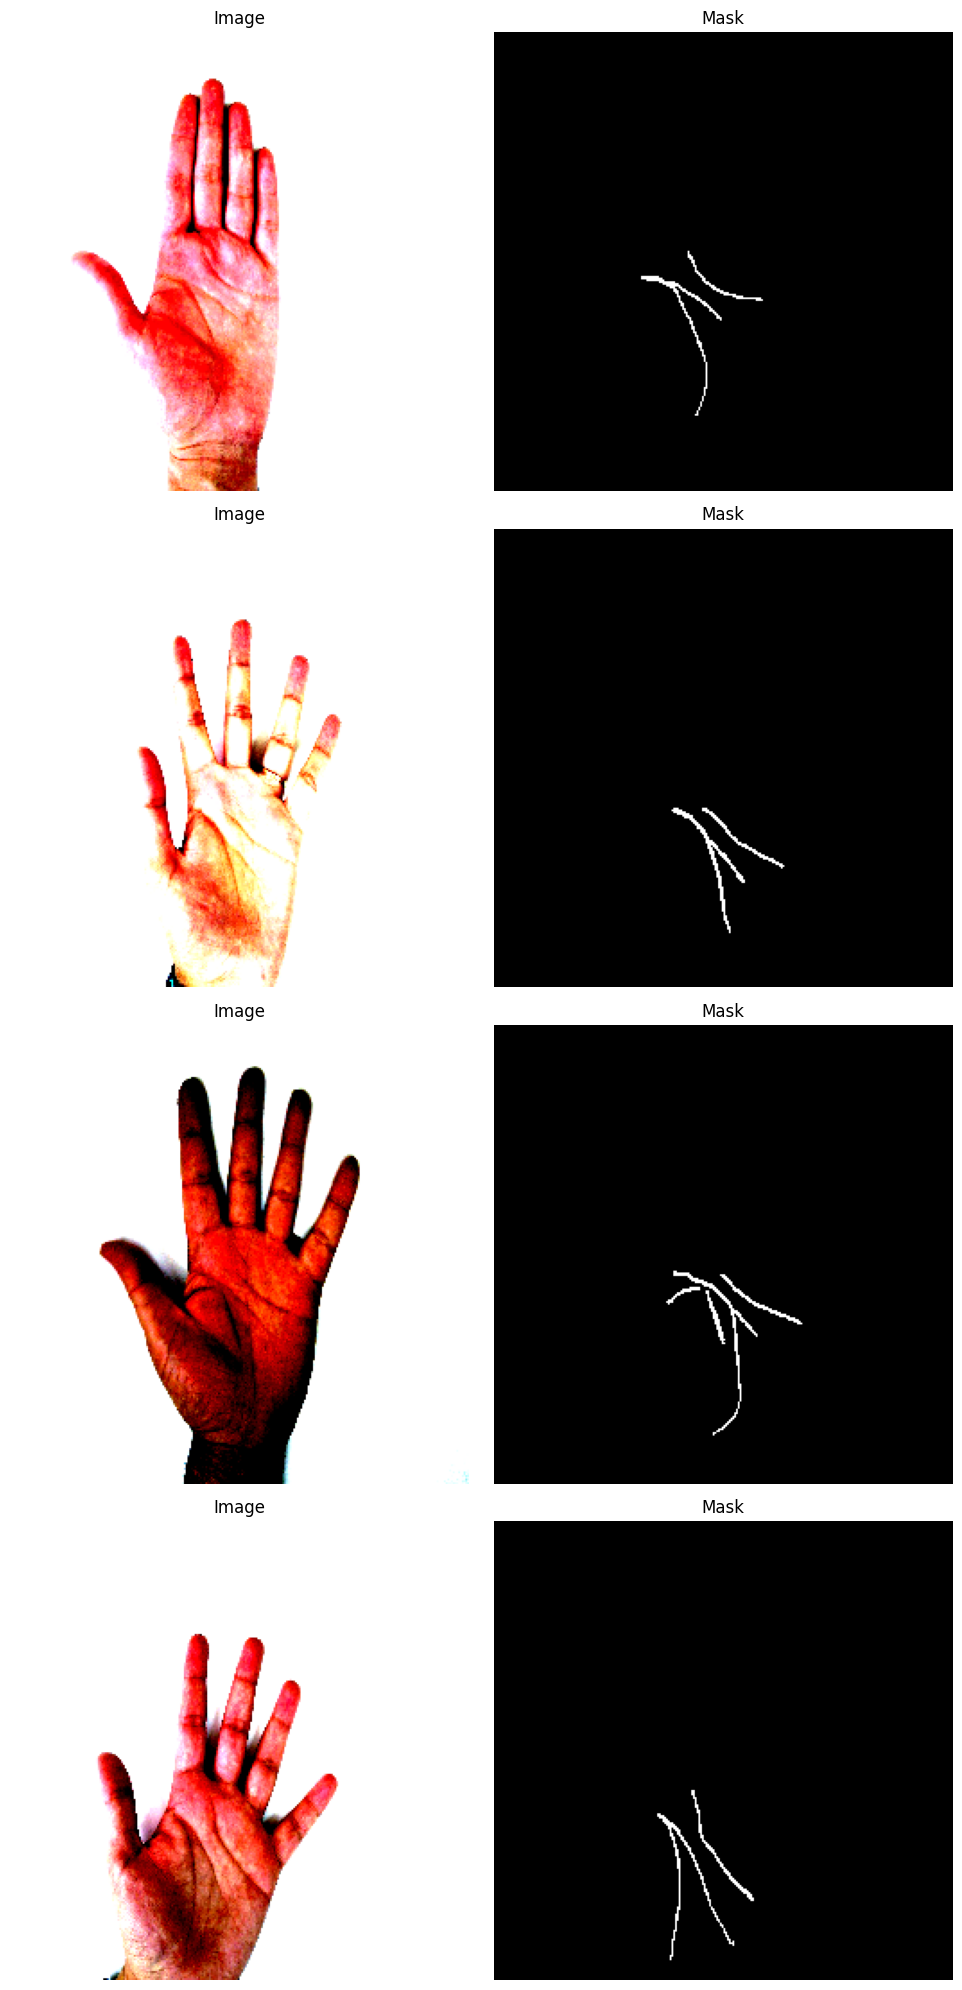

In [ ]:
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

# 첫 번째 배치 가져오기
images, masks = next(iter(train_loader))

# 이미지와 마스크 시각화
fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(10, 20))
for i in range(4):
    ax[i, 0].imshow(images[i].permute(1, 2, 0))  # 이미지
    ax[i, 1].imshow(masks[i], cmap='gray')  # 마스크
    ax[i, 0].set_title("Image")
    ax[i, 1].set_title("Mask")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")

plt.tight_layout()
plt.show()

# Define Model

In [8]:
resnet = torchvision.models.resnet.resnet50(pretrained=True)

class ConvBlock(nn.Module):
    """
    Helper module that consists of a Conv -> BN -> ReLU
    """

    def __init__(self, in_channels, out_channels, padding=1, kernel_size=3, stride=1, with_nonlinearity=True):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, padding=padding, kernel_size=kernel_size, stride=stride)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.with_nonlinearity = with_nonlinearity

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        if self.with_nonlinearity:
            x = self.relu(x)
        return x


class Bridge(nn.Module):
    """
    This is the middle layer of the UNet which just consists of some
    """

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.bridge = nn.Sequential(
            ConvBlock(in_channels, out_channels),
            ConvBlock(out_channels, out_channels)
        )

    def forward(self, x):
        return self.bridge(x)


class UpBlockForUNetWithResNet50(nn.Module):
    """
    Up block that encapsulates one up-sampling step which consists of Upsample -> ConvBlock -> ConvBlock
    """

    def __init__(self, in_channels, out_channels, up_conv_in_channels=None, up_conv_out_channels=None,
                 upsampling_method="conv_transpose"):
        super().__init__()

        if up_conv_in_channels == None:
            up_conv_in_channels = in_channels
        if up_conv_out_channels == None:
            up_conv_out_channels = out_channels

        if upsampling_method == "conv_transpose":
            self.upsample = nn.ConvTranspose2d(up_conv_in_channels, up_conv_out_channels, kernel_size=2, stride=2)
        elif upsampling_method == "bilinear":
            self.upsample = nn.Sequential(
                nn.Upsample(mode='bilinear', scale_factor=2),
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1)
            )
        self.conv_block_1 = ConvBlock(in_channels, out_channels)
        self.conv_block_2 = ConvBlock(out_channels, out_channels)

    def forward(self, up_x, down_x):
        """

        :param up_x: this is the output from the previous up block
        :param down_x: this is the output from the down block
        :return: upsampled feature map
        """
        x = self.upsample(up_x)
        x = torch.cat([x, down_x], 1)
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        return x


class UNetWithResnet50Encoder(nn.Module):
    DEPTH = 6

    def __init__(self, n_channels=3, n_classes=1):
        super().__init__()
        resnet = torchvision.models.resnet.resnet50(pretrained=True)
        down_blocks = []
        up_blocks = []

        # 입력 채널을 n_channels로 조정
        self.input_block = nn.Sequential(
            nn.Conv2d(n_channels, 64, kernel_size=7, stride=2, padding=3, bias=False),
            *list(resnet.children())[1:3]
        )
        self.input_pool = list(resnet.children())[3]

        for bottleneck in list(resnet.children()):
            if isinstance(bottleneck, nn.Sequential):
                down_blocks.append(bottleneck)
        self.down_blocks = nn.ModuleList(down_blocks)
        self.bridge = Bridge(2048, 2048)
        up_blocks.append(UpBlockForUNetWithResNet50(2048, 1024))
        up_blocks.append(UpBlockForUNetWithResNet50(1024, 512))
        up_blocks.append(UpBlockForUNetWithResNet50(512, 256))
        up_blocks.append(UpBlockForUNetWithResNet50(in_channels=128 + 64, out_channels=128,
                                                    up_conv_in_channels=256, up_conv_out_channels=128))
        up_blocks.append(UpBlockForUNetWithResNet50(in_channels=64 + 3, out_channels=64,
                                                    up_conv_in_channels=128, up_conv_out_channels=64))

        self.up_blocks = nn.ModuleList(up_blocks)

        self.out = nn.Conv2d(64, n_classes, kernel_size=1, stride=1)

    def forward(self, x, with_output_feature_map=False):
        pre_pools = dict()
        pre_pools[f"layer_0"] = x
        x = self.input_block(x)
        pre_pools[f"layer_1"] = x
        x = self.input_pool(x)

        for i, block in enumerate(self.down_blocks, 2):
            x = block(x)
            if i == (UNetWithResnet50Encoder.DEPTH - 1):
                continue
            pre_pools[f"layer_{i}"] = x

        x = self.bridge(x)

        for i, block in enumerate(self.up_blocks, 1):
            key = f"layer_{UNetWithResnet50Encoder.DEPTH - 1 - i}"
            x = block(x, pre_pools[key])
        output_feature_map = x
        x = self.out(x)
        del pre_pools
        if with_output_feature_map:
            return x, output_feature_map
        else:
            return x

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 142MB/s]


#Evaluate

In [9]:
# F-1 Score와 IoU 계산을 위한 함수
def calculate_f1_score(preds, labels):
    # 시그모이드 함수를 적용하여 확률로 변환
    preds = torch.sigmoid(preds)
    # 확률을 이진화 (0.5를 임계값으로 사용)
    preds = (preds > 0.5).float()

    # True Positives, False Positives, False Negatives 계산
    tp = (preds * labels).sum(dim=[1, 2, 3])
    fp = (preds * (1 - labels)).sum(dim=[1, 2, 3])
    fn = ((1 - preds) * labels).sum(dim=[1, 2, 3])

    # F1 Score 계산
    precision = tp / (tp + fp + 1e-6)
    recall = tp / (tp + fn + 1e-6)
    f1 = 2 * (precision * recall) / (precision + recall + 1e-6)

    # 배치 내 모든 이미지에 대한 F1 Score의 평균 반환
    return f1.mean().item()

def calculate_iou(preds, labels):
    # 시그모이드 함수를 적용하여 확률로 변환
    preds = torch.sigmoid(preds)
    # 확률을 이진화 (0.5를 임계값으로 사용)
    preds = (preds > 0.5).float()

    # True Positives, False Positives, False Negatives 계산
    intersection = (preds * labels).sum(dim=[1, 2, 3])  # 교집합
    total = (preds + labels).sum(dim=[1, 2, 3])  # 합집합
    union = total - intersection  # 합집합 - 교집합

    # IoU 계산
    iou = (intersection + 1e-6) / (union + 1e-6)  # 0으로 나누는 것을 방지하기 위한 작은 값 추가

    # 배치 내 모든 이미지에 대한 IoU의 평균 반환
    return iou.mean().item()


# Loss function

In [10]:
class DiceLoss(nn.Module):
    def __init__(self, smooth=1.):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, inputs, targets):
        # inputs : 모델 출력, targets : 실제 마스크
        inputs = torch.sigmoid(inputs)  # 시그모이드 함수를 적용하여 확률로 변환

        # 평탄화
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        # Dice 계수 계산
        intersection = (inputs * targets).sum()
        dice = (2.*intersection + self.smooth)/(inputs.sum() + targets.sum() + self.smooth)

        # Dice 손실
        return 1 - dice

#Train

In [20]:
#하이퍼 파라미터
num_epochs = 50
learning_rate = 0.001
T_max = 50  # 학습률 주기

# 최상의 모델을 저장하기 위한 초기 설정
best_iou_score = 0.0
early_stopping_counter = 0
patience = 10  # 성능이 개선되지 않는 에포크 한계값

# model 초기화
model = UNetWithResnet50Encoder(n_channels=3, n_classes=1).to(device)
model = model.to(device)

#loss function과 optimizer 정리
criterion = DiceLoss().to(device)
optimizer = optim.AdamW(model.parameters(), lr=learning_rate, betas=(0.9, 0.999), eps=1e-08, weight_decay=1e-4, amsgrad=False)

# CosineAnnealingLR 스케줄러 초기화
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=T_max, eta_min=1e-6)

# training loop
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for images, masks in tqdm(train_loader):
        images = images.float().to(device)
        masks = masks.float().to(device).unsqueeze(1)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
    #Learning Rate 조정
    scheduler.step()

    # Validation loop
    model.eval()
    val_loss = 0
    iou_scores = []
    f1_scores = []
    with torch.no_grad():
        for images, masks in tqdm(val_loader):  # val_loader는 검증 데이터셋에 대한 DataLoader입니다.
            images = images.float().to(device)
            masks = masks.float().to(device).unsqueeze(1)
            outputs = model(images)
            loss = criterion(outputs, masks)
            val_loss += loss.item()

            # F-1 Score와 IoU 계산
            f1 = calculate_f1_score(outputs, masks)
            iou = calculate_iou(outputs, masks)
            f1_scores.append(f1)
            iou_scores.append(iou)

    # 평균 IoU 및 손실 계산
    val_loss /= len(val_loader)
    avg_f1 = np.mean(f1_scores)
    avg_iou = np.mean(iou_scores)
    print(f'Epoch {epoch+1}, Loss: {epoch_loss/len(train_loader)}, Validation Loss: {val_loss}, Avg F-1: {avg_f1}, mIoU: {avg_iou}')

    # Early Stopping
    if avg_iou > best_iou_score:
        best_iou_score = avg_iou
        early_stopping_counter = 0
        # 가장 좋은 모델 저장
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        early_stopping_counter += 1
        if early_stopping_counter >= patience:
            print("Early stopping triggered")
            break

100%|██████████| 20/20 [00:19<00:00,  1.00it/s]


Epoch 1, Loss: 0.9089087169248979, Validation Loss: 0.8120655328035354, Avg F-1: 0.4662378191947937, mIoU: 0.3090831235051155


100%|██████████| 20/20 [00:19<00:00,  1.03it/s]


Epoch 2, Loss: 0.4724200243478293, Validation Loss: 0.3724713742733002, Avg F-1: 0.6475938081741333, mIoU: 0.4858865886926651


100%|██████████| 20/20 [00:18<00:00,  1.06it/s]


Epoch 3, Loss: 0.3124792261438055, Validation Loss: 0.31385177969932554, Avg F-1: 0.6893692284822464, mIoU: 0.5299373835325241


100%|██████████| 20/20 [00:18<00:00,  1.07it/s]


Epoch 4, Loss: 0.2883006170555785, Validation Loss: 0.28878604173660277, Avg F-1: 0.7099833607673645, mIoU: 0.5535278677940368


100%|██████████| 20/20 [00:18<00:00,  1.07it/s]


Epoch 5, Loss: 0.2785246070924696, Validation Loss: 0.2867044985294342, Avg F-1: 0.7134989827871323, mIoU: 0.5576526880264282


100%|██████████| 20/20 [00:18<00:00,  1.06it/s]


Epoch 6, Loss: 0.27081394785053126, Validation Loss: 0.28939167857170106, Avg F-1: 0.7087651193141937, mIoU: 0.5536847859621048


100%|██████████| 20/20 [00:18<00:00,  1.07it/s]


Epoch 7, Loss: 0.26708612926713715, Validation Loss: 0.27711921334266665, Avg F-1: 0.7209961861371994, mIoU: 0.567036584019661


100%|██████████| 20/20 [00:19<00:00,  1.02it/s]


Epoch 8, Loss: 0.26200654873481166, Validation Loss: 0.2730183243751526, Avg F-1: 0.7254664540290833, mIoU: 0.5723441690206528


100%|██████████| 20/20 [00:17<00:00,  1.12it/s]


Epoch 9, Loss: 0.258092048403981, Validation Loss: 0.28225394487380984, Avg F-1: 0.7161054700613022, mIoU: 0.5615865796804428


100%|██████████| 20/20 [00:18<00:00,  1.10it/s]


Epoch 10, Loss: 0.25369147612498355, Validation Loss: 0.26506505608558656, Avg F-1: 0.7328591972589493, mIoU: 0.5810444295406342


100%|██████████| 20/20 [00:18<00:00,  1.10it/s]


Epoch 11, Loss: 0.2519405484199524, Validation Loss: 0.268913134932518, Avg F-1: 0.7290657758712769, mIoU: 0.5763644188642502


100%|██████████| 20/20 [00:18<00:00,  1.07it/s]


Epoch 12, Loss: 0.24850548754681598, Validation Loss: 0.26862181425094606, Avg F-1: 0.7284480571746826, mIoU: 0.5760201752185822


100%|██████████| 20/20 [00:18<00:00,  1.11it/s]


Epoch 13, Loss: 0.24351275425690871, Validation Loss: 0.26612510085105895, Avg F-1: 0.7311096549034118, mIoU: 0.579070121049881


100%|██████████| 20/20 [00:17<00:00,  1.13it/s]


Epoch 14, Loss: 0.24155393275585804, Validation Loss: 0.2640182375907898, Avg F-1: 0.7334347426891327, mIoU: 0.58209388256073


100%|██████████| 20/20 [00:18<00:00,  1.08it/s]


Epoch 15, Loss: 0.2372513066281329, Validation Loss: 0.26368420720100405, Avg F-1: 0.7341360867023468, mIoU: 0.582743114233017


100%|██████████| 20/20 [00:18<00:00,  1.08it/s]


Epoch 16, Loss: 0.23505328120766106, Validation Loss: 0.28638252317905427, Avg F-1: 0.7126768082380295, mIoU: 0.5572295278310776


100%|██████████| 20/20 [00:18<00:00,  1.07it/s]


Epoch 17, Loss: 0.23161638110548585, Validation Loss: 0.2671389371156693, Avg F-1: 0.730566331744194, mIoU: 0.5784512996673584


100%|██████████| 20/20 [00:18<00:00,  1.09it/s]


Epoch 18, Loss: 0.22980611009912177, Validation Loss: 0.2630443572998047, Avg F-1: 0.7353664487600327, mIoU: 0.5843352258205414


100%|██████████| 20/20 [00:17<00:00,  1.13it/s]


Epoch 19, Loss: 0.22529202110164767, Validation Loss: 0.25383766293525695, Avg F-1: 0.7439445286989212, mIoU: 0.5948796093463897


100%|██████████| 20/20 [00:17<00:00,  1.11it/s]


Epoch 20, Loss: 0.22081608038682204, Validation Loss: 0.2603708624839783, Avg F-1: 0.7375421643257141, mIoU: 0.5872389495372772


100%|██████████| 20/20 [00:18<00:00,  1.10it/s]


Epoch 21, Loss: 0.21649859108767666, Validation Loss: 0.2549430191516876, Avg F-1: 0.7436362862586975, mIoU: 0.5946867138147354


100%|██████████| 20/20 [00:18<00:00,  1.08it/s]


Epoch 22, Loss: 0.21200103615666485, Validation Loss: 0.25493302643299104, Avg F-1: 0.7431752651929855, mIoU: 0.5941845834255218


100%|██████████| 20/20 [00:18<00:00,  1.07it/s]


Epoch 23, Loss: 0.20902339115247623, Validation Loss: 0.25453561544418335, Avg F-1: 0.7433141589164733, mIoU: 0.5942965507507324


100%|██████████| 20/20 [00:17<00:00,  1.11it/s]


Epoch 24, Loss: 0.20534733756557927, Validation Loss: 0.2593160331249237, Avg F-1: 0.7383036375045776, mIoU: 0.5885882645845413


100%|██████████| 20/20 [00:17<00:00,  1.11it/s]


Epoch 25, Loss: 0.20159156767876593, Validation Loss: 0.25772434175014497, Avg F-1: 0.7403894662857056, mIoU: 0.5910786390304565


100%|██████████| 20/20 [00:18<00:00,  1.09it/s]


Epoch 26, Loss: 0.198204178076524, Validation Loss: 0.2534651458263397, Avg F-1: 0.744778698682785, mIoU: 0.5965077221393585


100%|██████████| 20/20 [00:19<00:00,  1.04it/s]


Epoch 27, Loss: 0.19220649082582075, Validation Loss: 0.25390979945659636, Avg F-1: 0.7448521822690963, mIoU: 0.5966334819793702


100%|██████████| 20/20 [00:19<00:00,  1.04it/s]


Epoch 28, Loss: 0.1872724602510641, Validation Loss: 0.2540766716003418, Avg F-1: 0.744380670785904, mIoU: 0.5962255775928498


100%|██████████| 20/20 [00:18<00:00,  1.07it/s]


Epoch 29, Loss: 0.1825488262124114, Validation Loss: 0.252498584985733, Avg F-1: 0.7460982084274292, mIoU: 0.5984296053647995


100%|██████████| 20/20 [00:18<00:00,  1.06it/s]


Epoch 30, Loss: 0.17821760950507698, Validation Loss: 0.2536685436964035, Avg F-1: 0.7449685961008072, mIoU: 0.5972314834594726


100%|██████████| 20/20 [00:17<00:00,  1.11it/s]


Epoch 31, Loss: 0.173901080430209, Validation Loss: 0.2507051914930344, Avg F-1: 0.7482420265674591, mIoU: 0.601427772641182


100%|██████████| 20/20 [00:18<00:00,  1.10it/s]


Epoch 32, Loss: 0.16915949491354135, Validation Loss: 0.25046667754650115, Avg F-1: 0.7485021650791168, mIoU: 0.6017612099647522


100%|██████████| 20/20 [00:18<00:00,  1.08it/s]


Epoch 33, Loss: 0.1645680050273518, Validation Loss: 0.25192511677742, Avg F-1: 0.7474634975194931, mIoU: 0.6005124986171723


100%|██████████| 20/20 [00:19<00:00,  1.04it/s]


Epoch 34, Loss: 0.16034320095083215, Validation Loss: 0.2505979597568512, Avg F-1: 0.748801451921463, mIoU: 0.6023449063301086


100%|██████████| 20/20 [00:18<00:00,  1.05it/s]


Epoch 35, Loss: 0.15574429781882318, Validation Loss: 0.25058993995189666, Avg F-1: 0.7488152533769608, mIoU: 0.602469402551651


100%|██████████| 20/20 [00:18<00:00,  1.05it/s]


Epoch 36, Loss: 0.15164152475503775, Validation Loss: 0.25144220888614655, Avg F-1: 0.7480835020542145, mIoU: 0.6017129361629486


100%|██████████| 20/20 [00:18<00:00,  1.06it/s]


Epoch 37, Loss: 0.14740895045982613, Validation Loss: 0.24980347156524657, Avg F-1: 0.7494540721178055, mIoU: 0.603502094745636


100%|██████████| 20/20 [00:18<00:00,  1.07it/s]


Epoch 38, Loss: 0.1439652960379045, Validation Loss: 0.252160969376564, Avg F-1: 0.747366401553154, mIoU: 0.6011355221271515


100%|██████████| 20/20 [00:19<00:00,  1.04it/s]


Epoch 39, Loss: 0.14016161515162542, Validation Loss: 0.2508834093809128, Avg F-1: 0.7483261793851852, mIoU: 0.6023766547441483


100%|██████████| 20/20 [00:18<00:00,  1.09it/s]


Epoch 40, Loss: 0.13688401927004804, Validation Loss: 0.25121326446533204, Avg F-1: 0.7481484293937684, mIoU: 0.602231103181839


100%|██████████| 20/20 [00:17<00:00,  1.13it/s]


Epoch 41, Loss: 0.13376779477674883, Validation Loss: 0.2510966330766678, Avg F-1: 0.7481741070747375, mIoU: 0.6023198276758194


100%|██████████| 20/20 [00:17<00:00,  1.12it/s]


Epoch 42, Loss: 0.13045516511896155, Validation Loss: 0.25049067139625547, Avg F-1: 0.7489780694246292, mIoU: 0.6035139769315719


100%|██████████| 20/20 [00:17<00:00,  1.11it/s]


Epoch 43, Loss: 0.127726571900504, Validation Loss: 0.25067619383335116, Avg F-1: 0.7488682299852372, mIoU: 0.6034084975719451


100%|██████████| 20/20 [00:17<00:00,  1.13it/s]


Epoch 44, Loss: 0.12579083835685645, Validation Loss: 0.25068334937095643, Avg F-1: 0.7488928020000458, mIoU: 0.6035250097513198


100%|██████████| 20/20 [00:17<00:00,  1.12it/s]


Epoch 45, Loss: 0.12373676077350156, Validation Loss: 0.2511039704084396, Avg F-1: 0.7484761774539948, mIoU: 0.6030818074941635


100%|██████████| 20/20 [00:17<00:00,  1.12it/s]


Epoch 46, Loss: 0.12245848938658997, Validation Loss: 0.2509984314441681, Avg F-1: 0.7485595166683197, mIoU: 0.6031608134508133


100%|██████████| 20/20 [00:17<00:00,  1.12it/s]


Epoch 47, Loss: 0.12121520723615374, Validation Loss: 0.25080831348896027, Avg F-1: 0.7489221900701523, mIoU: 0.6036658316850663


100%|██████████| 20/20 [00:18<00:00,  1.09it/s]


Epoch 48, Loss: 0.12059614684555557, Validation Loss: 0.2514135330915451, Avg F-1: 0.7482358068227768, mIoU: 0.6028152495622635


100%|██████████| 20/20 [00:18<00:00,  1.07it/s]


Epoch 49, Loss: 0.11994484034213392, Validation Loss: 0.2512244462966919, Avg F-1: 0.7484098762273789, mIoU: 0.6030458360910416


100%|██████████| 20/20 [00:18<00:00,  1.11it/s]

Epoch 50, Loss: 0.119708762719081, Validation Loss: 0.2510662227869034, Avg F-1: 0.7486020505428315, mIoU: 0.6032812386751175


#Test

In [21]:
import matplotlib.pyplot as plt
from torchvision.utils import save_image, make_grid
import numpy as np
import torch
from torch.utils.data import DataLoader, random_split
from PIL import Image

In [22]:
model.load_state_dict(torch.load('./best_model.pth'))

<All keys matched successfully>

In [23]:
#evaluate Test
# 모델을 평가 모드로 설정
model.eval()

# 점수 초기화
total_f1_score = 0.0
total_iou_score = 0.0
num_samples = 0

# 테스트 데이터셋에 대한 루프
for images, masks in test_loader:
    with torch.no_grad():
        # 데이터를 장치에 로드
        images = images.float().to(device)
        masks = masks.float().to(device).unsqueeze(1)

        # 모델 예측
        outputs = model(images)

        # F1 점수와 IoU 점수 계산
        f1 = calculate_f1_score(outputs, masks)
        iou = calculate_iou(outputs, masks)
        total_f1_score += f1
        total_iou_score += iou
        num_samples += 1

# 평균 F1 점수와 IoU 점수 출력
avg_f1_score = total_f1_score / num_samples
avg_iou_score = total_iou_score / num_samples
print(f"Average F1 Score on Test Set: {avg_f1_score}")
print(f"Average IoU Score on Test Set: {avg_iou_score}")

Average F1 Score on Test Set: 0.7467778861522675
Average IoU Score on Test Set: 0.6009290874004364


#Test 1 | f1: 0.7333370447158813, iou: 0.58210289478302


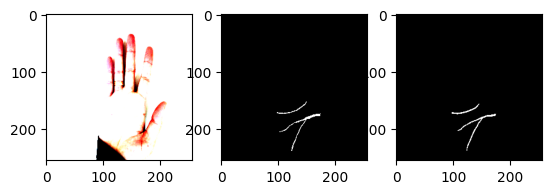

#Test 2 | f1: 0.725384533405304, iou: 0.5752876400947571


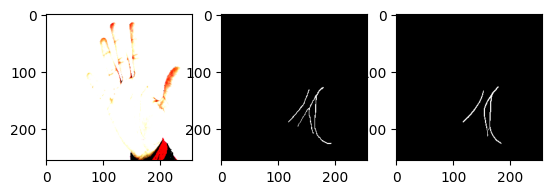

#Test 3 | f1: 0.7399856448173523, iou: 0.5909681916236877


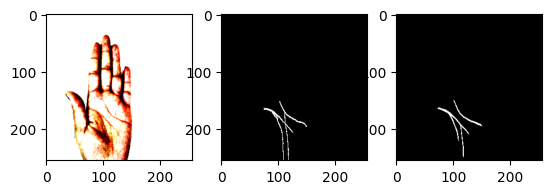

#Test 4 | f1: 0.7450419664382935, iou: 0.5985851287841797


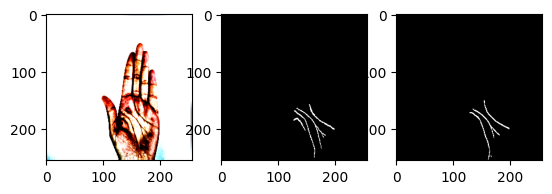

#Test 5 | f1: 0.7611966729164124, iou: 0.6187793016433716


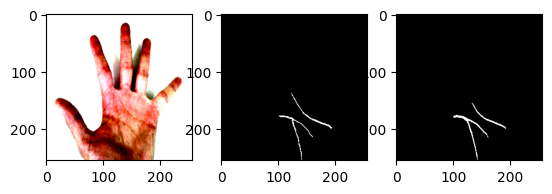

#Test 6 | f1: 0.7266731262207031, iou: 0.5782886743545532


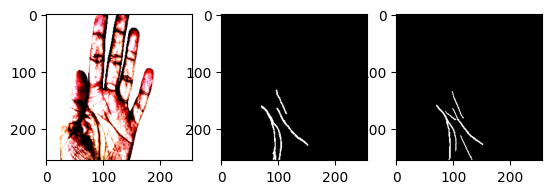

#Test 7 | f1: 0.747876763343811, iou: 0.6013861298561096


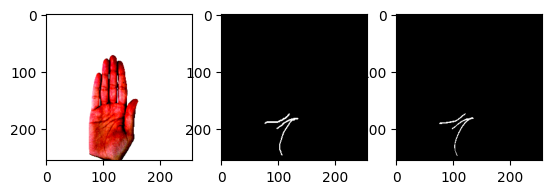

#Test 8 | f1: 0.7477214336395264, iou: 0.604116678237915


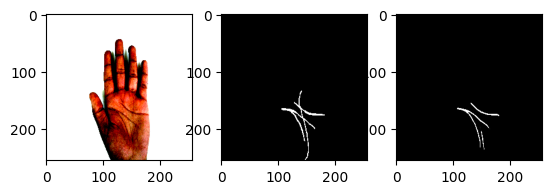

#Test 9 | f1: 0.7394484281539917, iou: 0.5887856483459473


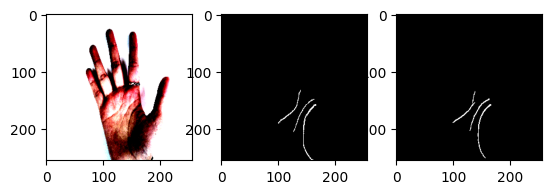

#Test 10 | f1: 0.7566813826560974, iou: 0.6156499981880188


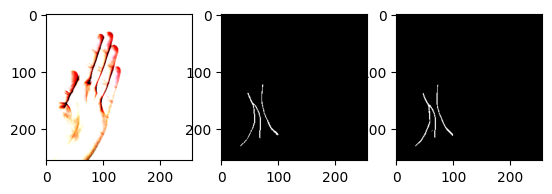

In [24]:
#Print Test Mask
model.eval()

k = 1
f1_scores = []
iou_scores = []
for images, masks in test_loader:
    if k > 10:
        break
    with torch.no_grad():
        images = images.float().to(device)
        masks = masks.float().to(device).unsqueeze(1)
        outputs = model(images)

        # F1와 IoU 계산
        f1 = calculate_f1_score(outputs, masks)
        iou = calculate_iou(outputs, masks)
        f1_scores.append(f1)
        iou_scores.append(iou)

        print(f"#Test {k} | f1: {f1}, iou: {iou}")

        # 시각화
        img_cpu = images[0].cpu().numpy().transpose(1, 2, 0)  # 첫 번째 이미지 선택
        mask_cpu = masks[0].squeeze().cpu().numpy()           # 첫 번째 마스크 선택
        output_sigmoid = torch.sigmoid(outputs[0]).squeeze().cpu().numpy()  # 첫 번째 출력 선택, 채널 차원 제거
        plt.subplot(1, 3, 1)
        plt.imshow(img_cpu)
        plt.subplot(1, 3, 2)
        plt.imshow(mask_cpu, cmap='gray')
        plt.subplot(1, 3, 3)
        plt.imshow(output_sigmoid, cmap='gray')
        plt.show()
        k += 1

#Experiments

In [ ]:
pip install pyheif

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.8/9.8 MB 41.4 MB/s eta 0:00:00


In [ ]:
import pyheif

In [ ]:
def heic_to_jpeg(heic_dir, jpeg_dir):

    heif_file = pyheif.read(heic_dir)

    image = Image.frombytes(
        heif_file.mode,
        heif_file.size,
        heif_file.data,
        "raw",
        heif_file.mode,
        heif_file.stride
        )

    print(heif_file)
    image.save(jpeg_dir,"JPEG")

In [ ]:
heic_to_jpeg("./inputs/IMG_6732.HEIC", "./inputs/IMG_6732.jpg")

<HeifFile 4032x3024 RGB with 36578304 bytes data>


In [16]:
# 단일 이미지에 대한 전처리 및 데이터 증강을 수행하는 함수
def preprocess_image(img_path, size=(256, 256)):
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # 데이터 증강 및 전처리 파이프라인
    transform = A.Compose([
        A.Resize(*size),
        A.Normalize(),
        ToTensorV2()
    ])

    # 변환 적용
    transformed = transform(image=image)
    return transformed['image']

In [17]:
# 단일 이미지를 검출하는 함수
def detect(jpeg_dir, model, device, save=True):
    # 이미지 전처리
    image = preprocess_image(jpeg_dir)

    # 모델 예측
    with torch.no_grad():
        image = image.float().unsqueeze(0).to(device)
        outputs = model(image)

    # 시각화
    pil_img = Image.open(jpeg_dir).convert('RGB').resize((256, 256), resample=Image.NEAREST)
    img_cpu = image.squeeze(0).cpu().numpy().transpose(1, 2, 0)
    output_sigmoid = torch.sigmoid(outputs).squeeze(0).cpu().numpy().squeeze()  # 첫 번째 차원 제거

    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.imshow(pil_img)
    plt.title('Original Image')

    plt.subplot(1, 2, 2)
    plt.imshow(output_sigmoid, cmap='gray')  # 2차원 배열
    plt.title('Predicted Mask')
    plt.show()

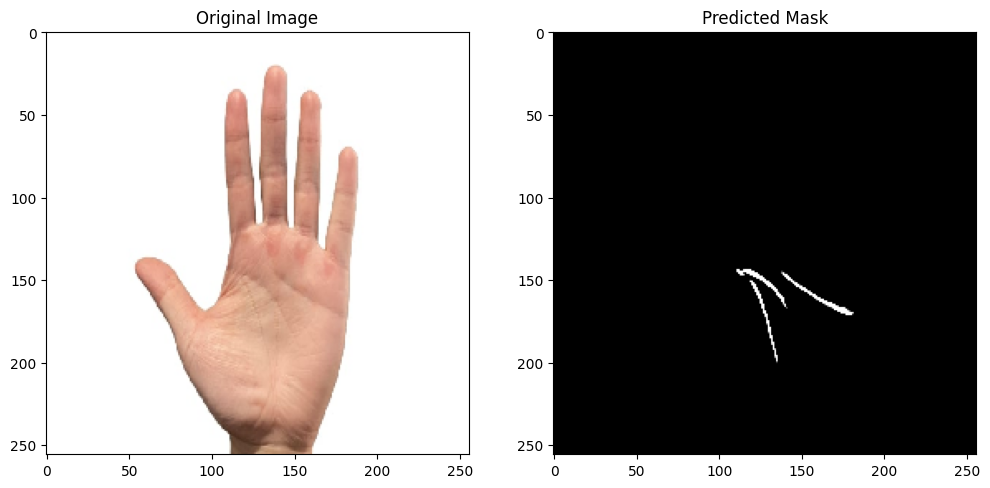

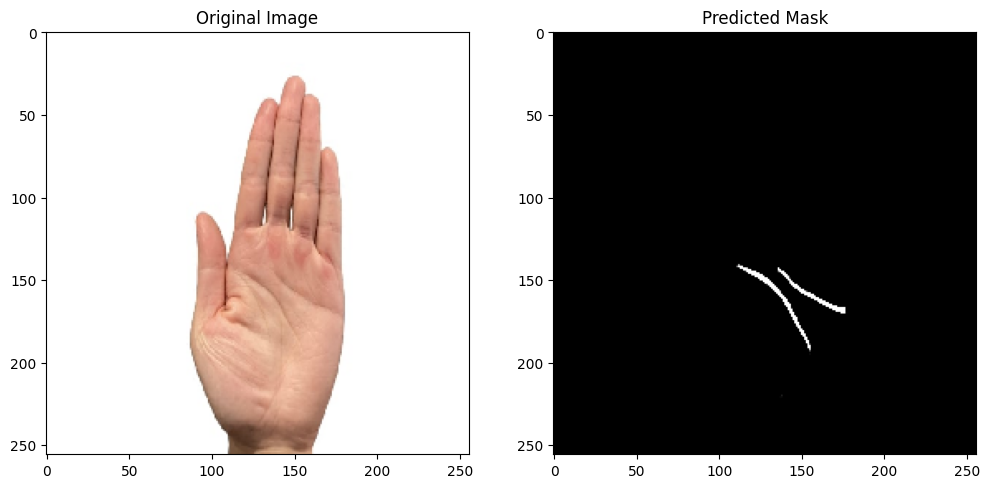

In [18]:
detect("/content/hand1_1.jpg",model,device)
detect("/content/hand1_2.jpg",model,device)

In [ ]:
detect("./inputs/hand2_1.jpeg")
detect("./inputs/hand2_2.jpeg")
detect("./inputs/hand2_3.jpg")
detect("./inputs/hand2_4.jpg")

In [ ]:
detect("./inputs/hand4_1.jpeg")
detect("./inputs/hand4_2.jpeg")
detect("./inputs/hand4_3.jpg")
detect("./inputs/hand4_4.jpg")